In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import xgboost as xgb
sns.set_style('darkgrid')

font = {'size': 18}
matplotlib.rc('font', **font)

In [2]:
df = pd.read_pickle("data/train.pkl")
df['viral'] = df['score'] >= 50

In [145]:
df.head()

,id,author,title,selftext,time,date,score,num_comments,viral
54442,n97ehm,weremanthing,Refinance my home to free up VA loan or wait?,First let me say thank you for looking at my p...,11:20:52,2021-05-10,1,2,False
41531,nzf89i,b1ackcat,Thank you for being such a great resource; you...,[removed],01:08:32,2021-06-14,1,2,False
61126,mxntnt,runnerup,"401k vs 457b, not sure which to max first",My work has both the 401k and 457b plans. They...,12:50:32,2021-04-24,3,7,False
87222,lg8t6y,Bunburier,"Student Loans, Interest Rate, and Payment Stra...",I'll be attending graduate school soon. Tuitio...,12:44:56,2021-02-09,2,2,False
34549,obzx08,Mxnchkinz_,What do I put under Gross Income when applying...,I'm applying for a Discover Secured Credit Car...,21:27:28,2021-07-01,0,15,False


In [198]:
len(df)

124941

Following the [tutorial](https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751) from Towards Data Science by Charlene Chambliss called "Using word2vec to Analyze News Headlines and Predict Article Success"

## Creating word vectors

In [184]:
# Grab all the titles
post_titles = df['title']

# Create a list of strings, one for each title
titles_list = [title for title in post_titles]

# Collapse the list of strings into a single long string for processing
big_title_string = ' '.join(titles_list)

from nltk.tokenize import word_tokenize

# Tokenize the string into words
tokens = word_tokenize(big_title_string) # had to run "import nltk & nltk.download('punkt')" before this worked

# Remve non-alphabetic tokens, such as punctuation
words = [word.lower() for word in tokens if word.isalpha()] # takes several seconds

In [29]:
# Filter out stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) # had to run "import nltk & nltk.download('stopwords')" before this worked

words = [word for word in words if not word in stop_words]

# Print first 10 words
words[:10]

['refinance',
 'home',
 'free',
 'va',
 'loan',
 'wait',
 'thank',
 'great',
 'resource',
 'saved']

Loading in a pre-trained word2vec model.

First, load and unzip the Googlenews vectors negative300 bin by entering the following into the command line:
wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
gzip -d GoogleNews-vectors-negative300.bin.gz

The above takes around 20 minutes, as the file is 3.4 GB. 

In [35]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 

The above started at 12:42pm, and was still running at 12:57pm. It finished by 1:34pm (after a walk outside). So, the above takes between 15 and 52 minutes. Will be timing subsequent methods.

In [36]:
economy_vec = model['economy']
economy_vec[:20]

array([ 0.18847656, -0.0703125 , -0.16113281,  0.03857422, -0.04956055,
       -0.23046875, -0.15722656, -0.16992188,  0.17089844, -0.01208496,
       -0.16015625, -0.02770996,  0.05932617,  0.00491333, -0.13769531,
        0.39257812,  0.06201172,  0.30859375,  0.12890625, -0.07373047],
      dtype=float32)

In [39]:
import time
tic = time.perf_counter()
# Filter the list of vectors to include only those that Word2Vec has a vector for
vector_list = [model[word] for word in words if word in model.index_to_key]
toc = time.perf_counter()
print(f"Took {toc - tic:0.2f} seconds")

Took 793.31 seconds


In [44]:
word2vecwords = model.index_to_key # contains 3 million words
tic = time.perf_counter()
# Filter the list of vectors to include only those that Word2Vec has a vector for
words_filtered = [word for word in words if word in word2vecwords]
toc = time.perf_counter()
print(f"Took {toc - tic:0.2f} seconds")

In [45]:
# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

In [46]:
# Cast to a dict so we can turn it into a data frame
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index') # 15105 rows and 300 columns


In [47]:
word_vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
refinance,0.116211,-0.086914,-0.050781,0.022217,0.143555,-0.030151,0.316406,0.245117,0.542969,-0.033203,...,-0.277344,0.750000,-0.550781,-0.042969,0.141602,0.345703,0.058838,0.310547,-0.087402,-0.253906
home,-0.011841,0.079590,0.016846,-0.089844,0.086426,0.024170,0.025513,-0.189453,0.141602,0.084473,...,-0.195312,0.039307,-0.109863,0.007507,0.058838,-0.052002,-0.029907,-0.136719,0.153320,-0.007935
free,0.157227,-0.072754,-0.027710,0.202148,-0.004517,0.094238,0.053955,0.006012,0.098145,0.174805,...,0.033936,-0.078613,-0.044434,-0.060547,0.106934,0.062256,0.006500,-0.169922,-0.001717,-0.052002
va,-0.120117,0.076172,0.320312,0.000912,0.138672,0.218750,0.100098,-0.107422,-0.185547,0.263672,...,0.033691,0.173828,-0.069336,0.097656,0.202148,-0.169922,-0.031494,-0.119141,0.047363,0.079590
loan,0.058838,0.357422,0.128906,-0.162109,0.291016,-0.040527,0.359375,-0.056396,0.326172,-0.080078,...,-0.363281,0.425781,-0.427734,-0.155273,0.128906,0.118652,-0.054688,0.145508,-0.093750,-0.226562


In [48]:
# save resulting data frame
word_vec_df.to_pickle("./data/word_vec_train.pkl")

## Dimensionality reduction

In [50]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(word_vec_df[:400]) 

In [1]:
sns.set()

fig, ax = plt.subplots(figsize=(11.7,8))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(1, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word,1], word_vec_df.index[word], fontsize=14))
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
        expand_points = (2,1), expand_text = (1,2),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
plt.show()

NameError: name 'sns' is not defined

## Averaging Word Embeddings

Now we shall try averaging the embeddings of the word vectors in each document.

In [88]:
def document_vector(model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.index_to_key]
    return np.mean([model[word] for word in doc], axis=0) # return average of word embeddings for the document
    
# Earlier preprocessing was done when we were only dealing with word vectors. 
# Here, we need each document to remain a document
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()]
    return doc

# Function that will help us drop documents that have no word vectors in word2vec
def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the word2vec dictionary"""
    return not all(word not in word2vec_model.index_to_key for word in doc)

# Filter out documents
def filter_docs(corpus, texts, condition_on_doc):
    """
    Filter corpus and texts given the function condition_on_doc which
    takes a doc. The document doc is kept if condition_on_doc(doc) is true
    """
    number_of_docs = len(corpus)
    if texts is not None:
        texts = [text for (text, doc) in zip(texts, corpus) if condition_on_doc(doc)]
    
    corpus = [doc for doc in corpus if condition_on_doc(doc)]
    
    print("{} docs removed".format(number_of_docs - len(corpus)))
    
    return (corpus, texts)

Now running the processing:

In [185]:
# Preprocess the corpus (takes 30 seconds)
tic = time.perf_counter()
corpus = [preprocess(title) for title in titles_list]
toc = time.perf_counter()
print(f"Took {toc - tic:0.2f} seconds")

Took 27.47 seconds


In [186]:
# Remove docs that don't include any words in W2V's vocab (takes around 350 seconds)
tic = time.perf_counter()
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: has_vector_representation(model, doc))
toc = time.perf_counter()
print(f"Took {toc - tic:0.2f} seconds")

412 docs removed
Took 353.69 seconds


In [187]:
# Filter out any empty docs
tic = time.perf_counter()
corpus, titles_list = filter_docs(corpus, titles_list, lambda doc: (len(doc) != 0))
toc = time.perf_counter()
print(f"Took {toc - tic:0.2f} seconds")

0 docs removed
Took 0.30 seconds


In [188]:
# Compute document vectors for each doc in the corpus (means of word vecs) (takes around 800 seconds)
tic = time.perf_counter()
x = []
for doc in corpus:
    x.append(document_vector(model, doc))
toc = time.perf_counter()
print(f"Took {toc - tic:0.2f} seconds")

Took 815.81 seconds


In [189]:
X = np.array(x)

## Dimensionality Reduction on Document Vectors

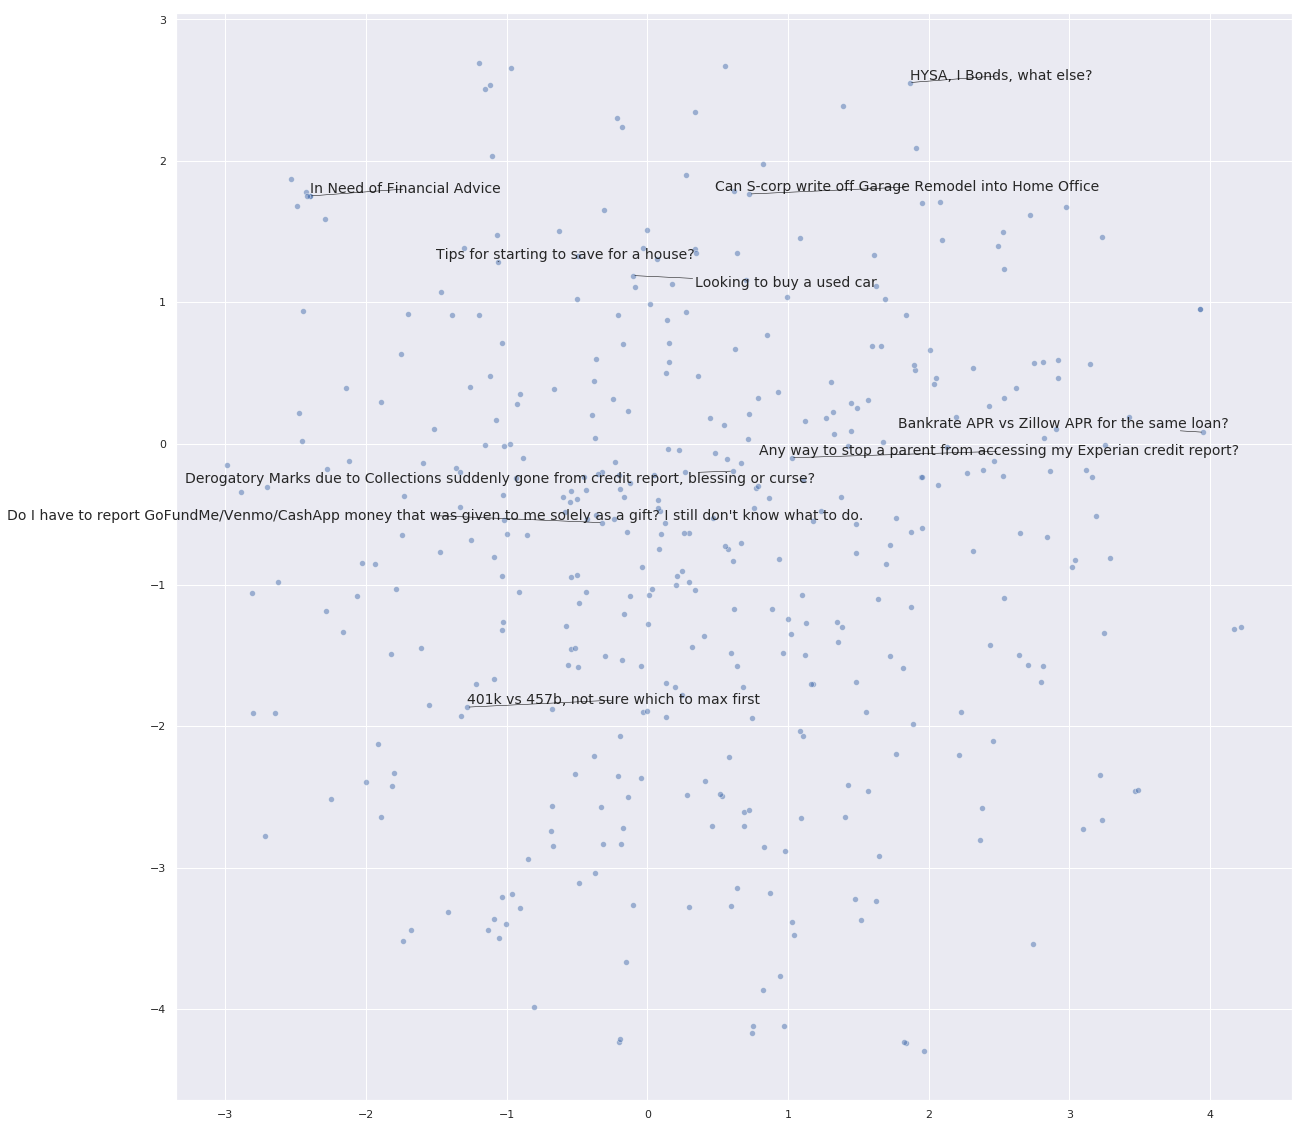

In [190]:
# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 42, perplexity = 100)

tsne_df = tsne.fit_transform(X[:400])

fig, ax = plt.subplots(figsize = (20, 20))

sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

texts = []
titles_to_plot = list(np.arange(2, 400, 40)) # plots every 40th title in first 400 titles

# Append words to list
for title in titles_to_plot:
    texts.append(plt.text(tsne_df[title, 0], tsne_df[title, 1], titles_list[title], fontsize=14))
    
# Plot text using adjust_text
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Save the data frame of the 300-dimension document vectors with the corresponding titles

In [191]:
doc_vec_df = pd.DataFrame(X)

In [192]:
doc_vec_df['title'] = titles_list

In [193]:
doc_vec_df.to_pickle("./data/doc_vec_train.pkl")

## Model Construction

Reduce the dimension of the document vectors to 15 using PCA

In [194]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 15, random_state=10)

reduced_vecs = pca.fit_transform(x)

In [195]:
df_w_vectors = pd.DataFrame(reduced_vecs)

df_w_vectors['title'] = titles_list

In [196]:
df_w_vectors.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,title
0,0.452326,-0.086981,-0.324988,0.465590,-0.066195,0.153091,0.265473,-0.236472,-0.074479,0.012487,-0.211550,-0.138849,-0.121593,0.031448,-0.058353,Refinance my home to free up VA loan or wait?
1,-0.330507,-0.260508,0.014901,-0.104928,0.199151,-0.119055,0.179098,-0.125544,0.072447,-0.076675,0.038906,0.045916,-0.039466,0.006943,0.057752,Thank you for being such a great resource; you...
2,-0.442264,0.236218,-0.431406,0.248370,0.024640,-0.151823,0.247016,-0.373945,-0.026743,-0.093129,-0.213248,0.116387,0.016804,-0.125650,-0.112207,"401k vs 457b, not sure which to max first"
3,0.518975,0.057408,-0.083401,-0.112960,0.102538,0.091286,-0.130520,-0.079133,-0.188288,0.125392,-0.044068,-0.141591,0.330608,-0.014323,-0.204374,"Student Loans, Interest Rate, and Payment Stra..."
4,0.347334,0.138867,-0.262790,-0.272617,-0.031099,-0.324284,0.063304,0.035924,0.019836,-0.153669,0.081983,0.041749,-0.259511,-0.027447,-0.085711,What do I put under Gross Income when applying...


In [211]:
len(df_w_vectors.title)

124529

In [210]:
len(set(df_w_vectors.title))

122105

Add the 15 new features to the original data set

In [204]:
main_w_vectors = pd.merge(df, df_w_vectors, on='title')

In [205]:
# drop vectors that couldn't be matched with the main_df
main_w_vectors.dropna(axis=0, inplace=True)

In [206]:
len(main_w_vectors.index)

132974

In [182]:
main_w_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,14,title,id,author,selftext,time,date,score,num_comments,viral
0,0.452326,-0.086981,-0.324988,0.465590,-0.066195,0.153091,0.265473,-0.236472,-0.074479,0.012487,...,-0.058353,Refinance my home to free up VA loan or wait?,n97ehm,weremanthing,First let me say thank you for looking at my p...,11:20:52,2021-05-10,1,2,False
1,-0.330507,-0.260508,0.014901,-0.104928,0.199151,-0.119055,0.179098,-0.125544,0.072447,-0.076675,...,0.057752,Thank you for being such a great resource; you...,nzf89i,b1ackcat,[removed],01:08:32,2021-06-14,1,2,False
2,-0.442264,0.236218,-0.431406,0.248370,0.024640,-0.151823,0.247016,-0.373945,-0.026743,-0.093129,...,-0.112207,"401k vs 457b, not sure which to max first",mxntnt,runnerup,My work has both the 401k and 457b plans. They...,12:50:32,2021-04-24,3,7,False
3,0.518975,0.057408,-0.083401,-0.112960,0.102538,0.091286,-0.130520,-0.079133,-0.188288,0.125392,...,-0.204374,"Student Loans, Interest Rate, and Payment Stra...",lg8t6y,Bunburier,I'll be attending graduate school soon. Tuitio...,12:44:56,2021-02-09,2,2,False
4,0.347334,0.138867,-0.262790,-0.272617,-0.031099,-0.324284,0.063304,0.035924,0.019836,-0.153669,...,-0.085711,What do I put under Gross Income when applying...,obzx08,Mxnchkinz_,I'm applying for a Discover Secured Credit Car...,21:27:28,2021-07-01,0,15,False


We shall also add columns for the day of the week and hour of day.

In [125]:
main_w_vectors['hour'] = [dt.hour for dt in main_w_vectors['time']]

main_w_vectors['weekday'] = [dt.weekday() for dt in main_w_vectors['date']]

Extract only the columns with numeric data:

In [ ]:
cols_to_drop = ['title', 'id', 'author', ]